# Prerequisite

This section is used to import packages to load data/files for the contents of this report. To run this notebook, change the FLUENT_HOME environment variable to the address of this repository

In [1]:
# Setting PYTHONPATHs & ENVIRONMENT VARIABLEs
import os
import sys
os.environ['FLUENT_HOME'] = r"C:\Users\lupus\OneDrive\GIT\OwnProjects\Speech Recognition\speech-to-intent"
sys.path.append(os.environ['FLUENT_HOME'] + '\\src')

In [2]:
from IPython import display
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from trainer import Trainer

data = {}
data['train'] = np.load('../data/data_for_training.npz')
data['test'] = np.load('../data/test_data.npz')

# Loading models, metrics and predictions of best model
best_model = '20210718130543'
metrics_df = pd.read_csv(f'../result/accuracies/{best_model}_merged_metrics_df.csv')
predictions_df = pd.read_csv(f'../result/predictions/{best_model}_predictions_df.csv')
with open(f'../result/models/{best_model}_model.pkl', 'rb') as f:
    trainer = pickle.load(f)
    
# Loading metrics of all experimented models
all_experiment_df = []
for file in os.listdir(f'../result/accuracies/'):
    if file.endswith('.csv'):
        all_experiment_df.append(pd.read_csv(f'../result/accuracies/{file}'))
all_experiment_df = pd.concat(all_experiment_df).reset_index(drop=True)
all_experiment_df.drop('Unnamed: 0', axis=1, inplace=True)

# Loading learning curves of all experimented models
learning_curves_df = []
for file in os.listdir(f'../result/learning_curve/'):
    if file.endswith('.csv'):
        learning_curves_df.append(pd.read_csv(f'../result/learning_curve/{file}'))
learning_curves_df = pd.concat(learning_curves_df).reset_index(drop=True)
learning_curves_df.drop('Unnamed: 0', axis=1, inplace=True)

# 1. Introduction

### 1.1 Background
This project aims to design and implement a solution to recognize intents of speech using spectrograms. A train set consisting of 22,661 spectrograms and a test set consisting of 4,774 spectrograms are provided. Each spectrogram could be mapped to 1 out of 31 different intents. It is observed that the number of samples are evenly distributed among the 31 intents in both train dataset and test dataset

Figure 1a: Data Distribution


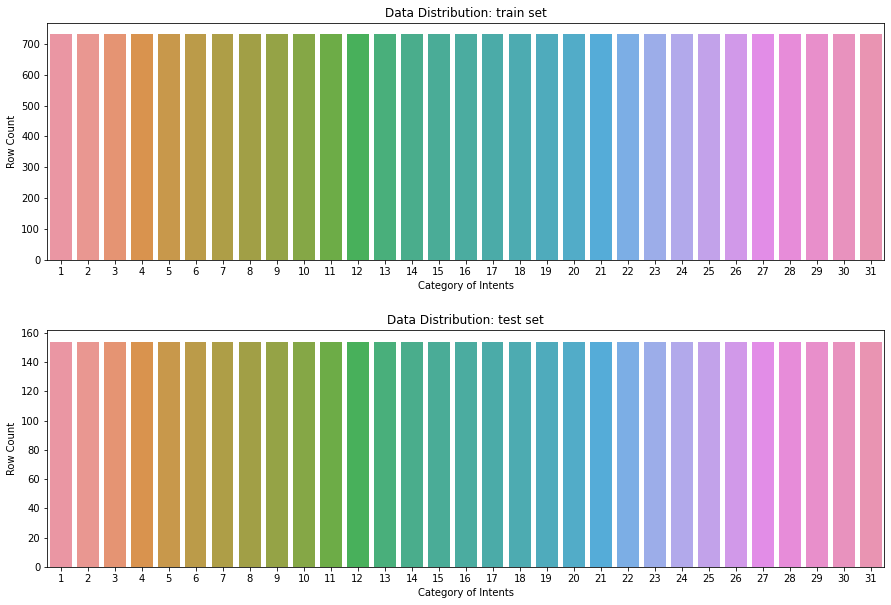

In [3]:
print("Figure 1a: Data Distribution")
fig, axes = plt.subplots(nrows=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.3)
for i, key in enumerate(data.keys()):
    unique, counts = np.unique(data[key]['f1'], return_counts=True)
    sns.barplot(x=unique, y=counts, ax=axes[i])
    axes[i].set_title(f'Data Distribution: {key} set')
    axes[i].set_xlabel('Category of Intents')
    axes[i].set_ylabel('Row Count')

### 1.2 Sample Data
Each spectrogram are arranged in a 3d array [sample, time, feature]. It is observed that each spectrogram shares the same number of dimensions. The time dimension is of size-300 while the feature dimension is of size-41. Below are some examples of the spectrograms from training dataset

Figure 1b: Sample spectrograms


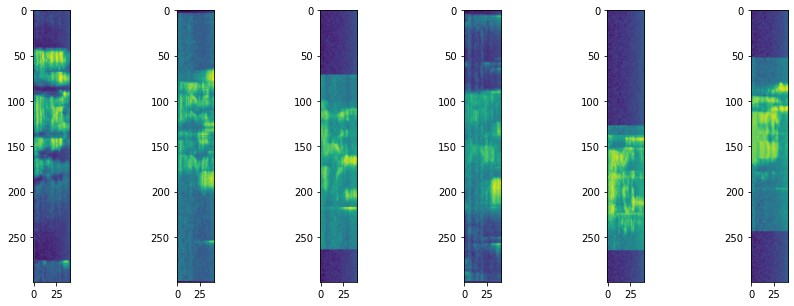

In [4]:
print("Figure 1b: Sample spectrograms")
fig, axes = plt.subplots(ncols=6, figsize=(15,5))
for i, index in enumerate(np.random.choice(a=data['train']['f0'].shape[0], size=6)):
    axes[i].imshow(data['train']['f0'][index])

# 2. Model Architecture 

A hybrid model mixing CNN, LSTM and MLP was trained. CNN layer was first applied to extract time-frequency features from the spectrogram. The CNN output was then fed into the LSTM layer to encode the features into a latent space over time. Lastly, the final output of the LSTM layer was fed into the MLP layer to give a 31-sized vector, each vector element representing a score given to each possible intent. The higher the score, the high probability of the intent.

### 2.1 CNN Parameters
The CNN layer consumes the raw spectrogram matrix to capture time-frequency features from the spectrogram. **16 kernels, each sized 3 (along the time-axis) \* 41 (along the feature-axis) with a dilation of 2 (along the time-axis) are used with a stride of 3 (along the time-axis)** to capture 16 different time-frequency representations from the spectrogram along the time-axis. Therefore, the total number of parameters of the CNN layer is 16\*3\*41+16=1984.

### 2.2 LSTM Parameters
The LSTM layer consumes the CNN output per timestamp to capture the long-term temporal contextual information from spectrogram. **The hidden state is set to be 64**, allowing the LSTM layer to encode the contextual information into a 64-sized latent space. Since the shape of CNN output per timestamp is 32, the total number of parameters of the LSTM layer is 256\*32+256+256\*64+256=25088.

### 2.3 MLP Parameters
The MLP layer consists of **31 neurons, summarizing the hidden state of shape 64** from the LSTM output into a 31-sized vector. Therefore, the total number of parameters of the MLP layer is 31\*64+31=2015.

Figure 2a. Model Architecture


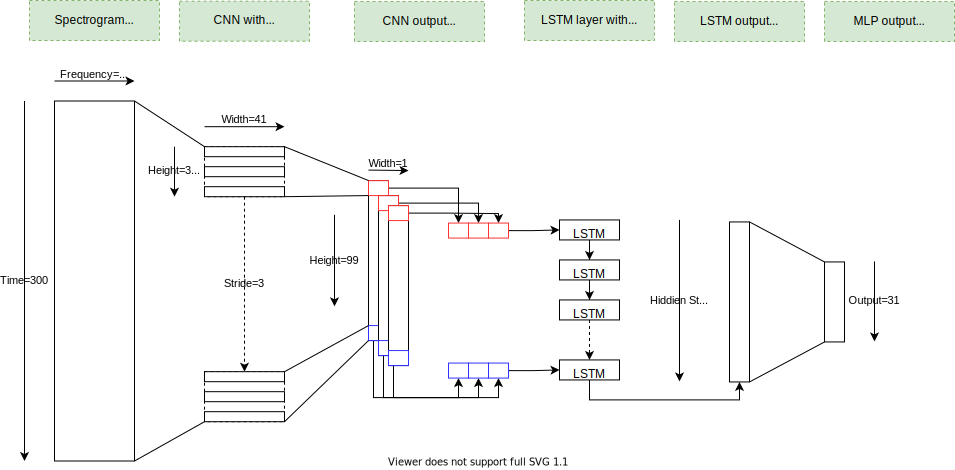

In [5]:
print("Figure 2a. Model Architecture")
display.display(display.SVG('./Model Architecture.svg'))

In [6]:
print("Figure 2b. Model Parameters\n")
for i, key in enumerate(trainer.model.state_dict().keys()):
    tab_num = '\t\t' if i not in [2,3,4,5] else '\t'
    print(f'{key}:{tab_num}', trainer.model.state_dict()[key].shape)

Figure 2b. Model Parameters

cnn.weight:		 torch.Size([16, 1, 3, 41])
cnn.bias:		 torch.Size([16])
lstm.weight_ih_l0:	 torch.Size([256, 16])
lstm.weight_hh_l0:	 torch.Size([256, 64])
lstm.bias_ih_l0:	 torch.Size([256])
lstm.bias_hh_l0:	 torch.Size([256])
linear.weight:		 torch.Size([31, 64])
linear.bias:		 torch.Size([31])


# 3. Training

### 1. Train-Validation Split
The training data was first **randomly splitted** into train set and validation set in order to support early stopping mechanism to avoids overfitting. **20%** of the training data was hold out as validation set with **stratified sampling**.

### 2. Loss Function, Epoch, Iteration, Batch Size & Learning Rate**  
The **cross-entropy** loss was used as the loss function. The model was trained with **200 epochs, 32 iterations, 1024 batch size and 0.01 learning rate**. Instead of going through the whole training set, each epoch sampled 32 batch of data from the training set with 1024 samples per batch by sampling with replacement.

### 3. Early Stopping
An early stopping mechanism was applied to avoid overfitting. After each epoch, the validation set was inferenced and the validation loss was recorded. **The training was early stopped when the validation loss failed to improve for 20 epochs**. Then, the model parameters right after the epoch with lowest validation loss were used as the final model for evaluation on test set.

### 4. Data Augmentation
In order to increase robustness of the model and reduce overfitting, data augmentation strategy was applied during training. Each mini-batch of training data were first augmented by both **time masking** and **frequency masking**. For time masking, **10% out of the 300 timestamps** per spectrogram were masked. For frequency masking, **10% out of 41 features** per spectrogram were masked. The masking value was the mean value of the spectrograms per mini-batch.

# 4. Results

To measure the result, a **softmax operation** was applied to the model's output in order to obtain the probability of each sample belonging to each possible intents. **The intent with the highest proability would be the predicted class of the model**. The **F1-Score, Recall and Precision** scores were then calculated for each intent. A **micro-average** of all 3 metrics were also calculated as an overall performance measure

Based on Figure 4a., **the F1-Score of Train, Validate and Test sets are 0.98, 0.92 and 0.88 respectively**. Diving into details, Figure 4b shows the recall & precision combination chart for each intents. The bars represent recall and the line represent precision. It is observed from the validation set that the model's **performance for intent 11, 12, 13, 16 and 17 are obviously worse than other intent**.

Figure 4a. F1-Score per Train, Validate & Test set
Figure 4b. Recall & Precision per Intent per Train, Validate & Test set


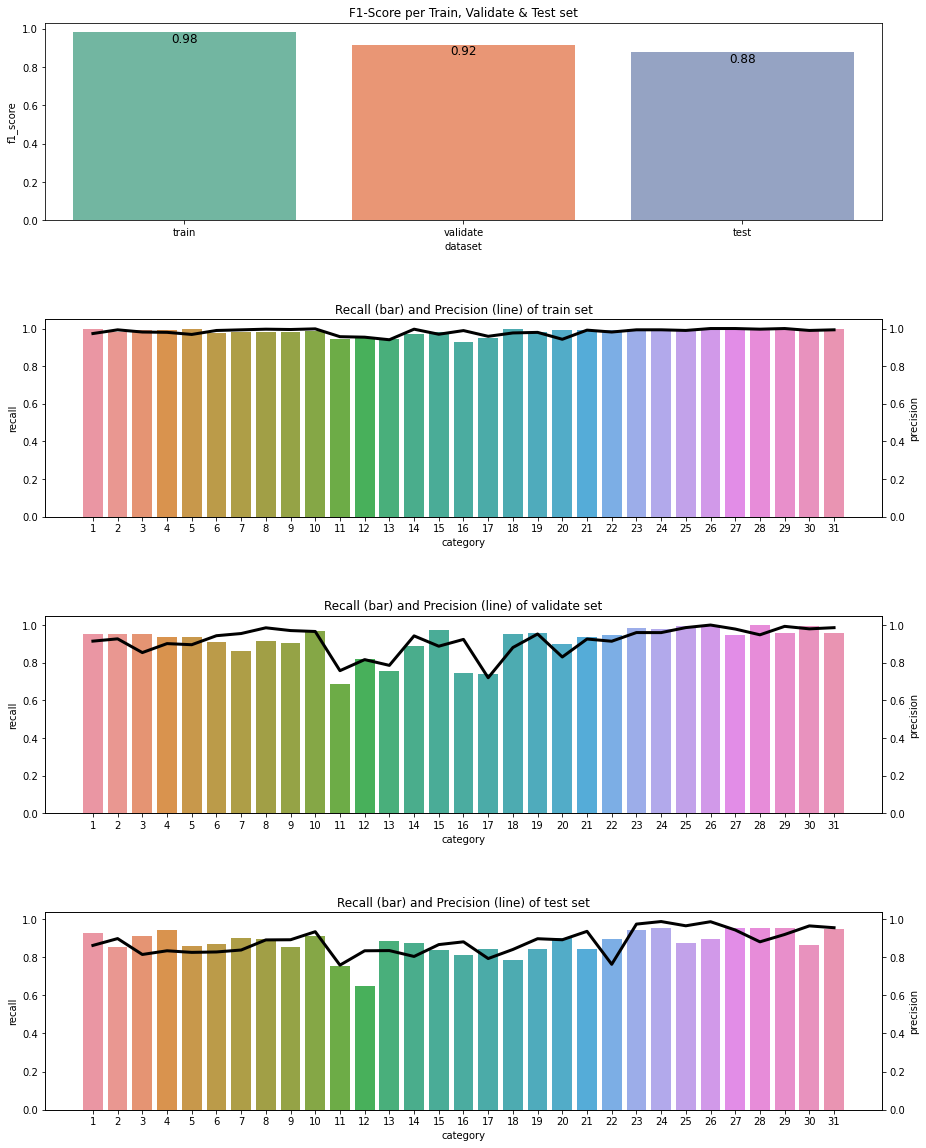

In [7]:
# Figure setting
print("Figure 4a. F1-Score per Train, Validate & Test set")
fig, axes = plt.subplots(nrows=4, figsize=(15, 20))
fig.subplots_adjust(hspace=0.5)

# F1-Score bar plot
axes[0].set_title('F1-Score per Train, Validate & Test set')
axes[0] = sns.barplot(data=metrics_df[metrics_df.category=='micro-average'],
                      x="dataset", y="f1_score", ax=axes[0], orient='v', palette='Set2')
cols_order = ['train', 'validate', 'test']
grouped_df = metrics_df[metrics_df.category=='micro-average'].groupby('dataset')['f1_score'].sum().reindex(cols_order)
for index, row in grouped_df.reset_index().iterrows():
    axes[0].text(index, row.f1_score, round(row.f1_score,2), color='black', ha='center', va="top", fontsize=12)
    
# Precision and Recall
print("Figure 4b. Recall & Precision per Intent per Train, Validate & Test set")
ax_pair = dict()
for idx, dataset in enumerate(cols_order, 1):
    df = metrics_df[(metrics_df.category!='micro-average') & (metrics_df.dataset == dataset)]
    sns.barplot(data=df, x="category", y="recall", ax=axes[idx])
    axes[idx].set_title(f'Recall (bar) and Precision (line) of {dataset} set')
    ax_pair[idx] = axes[idx].twinx()
    ax_pair[idx].sharey(axes[idx])
    ax_pair[idx] = sns.lineplot(data=df, x="category", y="precision", linewidth=3, color="black")

# 5. Discussion

### 1. Confusion Matrix 
As mentioned in the "Result" section, it is observed from the validation set that the model's **accuracy for intent 11, 12, 13, 16 and 17 are obviously worse than other intent**. One possible explaination is that these classes are similar to each other, making it hard for the model to distinguish them. To verify the hypothesis, the confusion matrices for Train, Validate & Test set are plotted below in Figure 5.

Based on the confusion matrix of the validation set, it seems that **the model is sometimes confused between some pair of intents** such as intent 11 & 12, intent 13 & 17 and intent 16 & 20. For example, as observed from the confusion matrix of validation set, 16 samples with intent-11 is predicted as as intent-12 while 11 samples with the intent=12 is predicted as intent-11.

Due to time constraints, not much investigation was conducted for these pairs of similar intents.

Figure 5a: Confusion Matrices


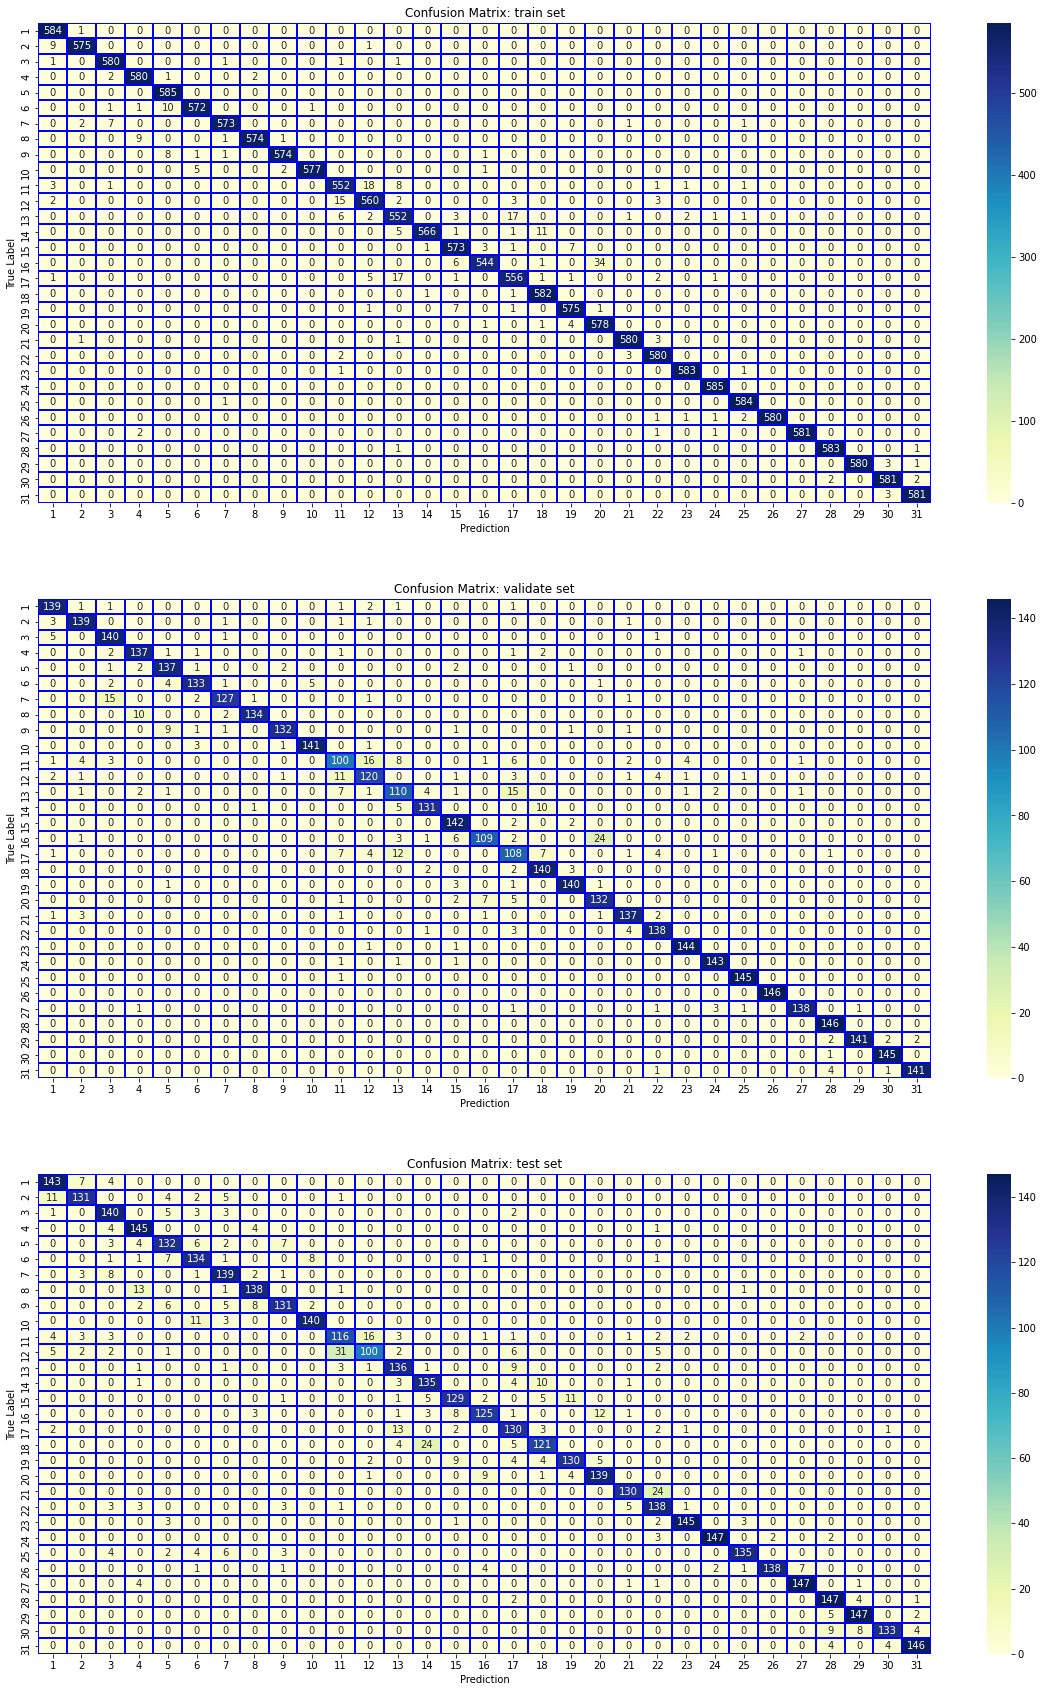

In [8]:
# Confusion Matrix
print("Figure 5a: Confusion Matrices")
tick_labels = [str(i + 1) for i in range(31)]
fig, axes = plt.subplots(nrows=3, figsize=(20, 10 * 3))
for idx, keys in enumerate(['train', 'validate', 'test']):
    df = predictions_df[predictions_df.dataset == keys]
    sns.heatmap(data=confusion_matrix(df.label, df.predicted_class), ax=axes[idx]
                , xticklabels=tick_labels, yticklabels=tick_labels
                , cbar=True, cmap='YlGnBu', linewidths=.1, linecolor='b', annot=True, fmt='d')
    axes[idx].set_title(f'Confusion Matrix: {keys} set')
    axes[idx].set_xlabel('Prediction')
    axes[idx].set_ylabel('True Label')

### 2. Importance of Data Augmentation

During model training, it is observed that the train loss droped significantly faster than the validation loss. The validation loss then soon stopped improving and ingtriggered the early stop mechanism. After applying the data augmentation strategy, we can observe from Figure 5b that the train loss dropped slower and only got below validation loss at around epoch 40 instead of epoch 10 where no data augmentation is applied. The resulting lowest validation loss is also lower, meaning the model can generalize better to unseen data.

One interesting thing to note is that without data augmentation, the train loss dropped quickly and suddenly exploded at around epoch 55. This suggest a lower learning rate should be used.

Figure 5b: Learning Curves


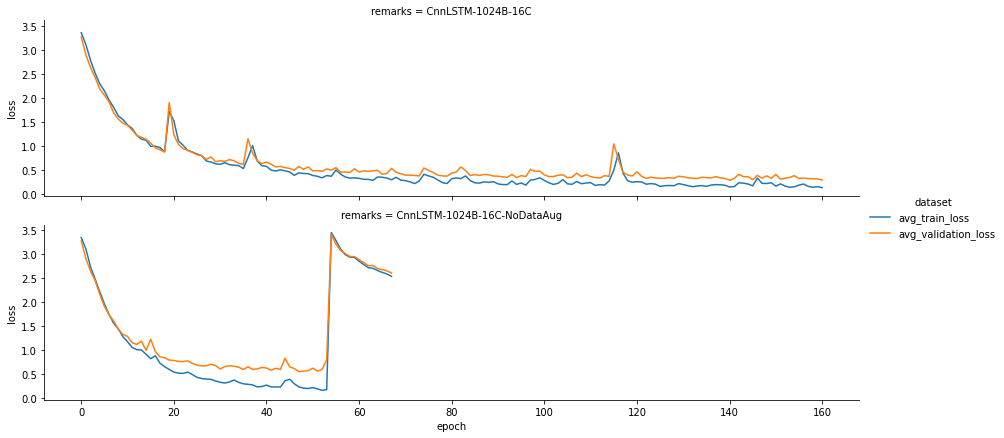

In [9]:
# Learning Curves
print("Figure 5b: Learning Curves")
remarks_filter = learning_curves_df.remarks.isin(['CnnLSTM-1024B-16C', 'CnnLSTM-1024B-16C-NoDataAug'])
df = pd.melt(frame=learning_curves_df[remarks_filter].reset_index(drop=True),
             id_vars=['epoch', 'remarks'], value_vars=['avg_train_loss', 'avg_validation_loss'],
             var_name='dataset', value_name='loss')

fig = sns.relplot(data=df, x="epoch", y="loss", hue="dataset", row="remarks", kind='line',
                  aspect=4, height=3, col_order=['CnnLSTM-1024B-16C-NoDataAug', 'CnnLSTM-1024B-16C'])

### 3. Importance of Batch Size

It appears that batch size plays a significant role in improving the accuracy of the model. 5 experiments were conducted with the CnnLSTM model using 32 kernels. The experiments start from setting batch_size=64 to setting batch_size=1024. We can observe that the F1-Score rises from 0.24 to 0.87 in validation set just by changing the batch size.

This is likely due to the fact the large batch size increases the chance of each batch to cover sufficient samples from each of the 31 intents, allowing the CNN and LSTM layer to have a more stable learning and to learn generalized representation of the spectrograms.

In [10]:
category_filter = all_experiment_df.category == 'micro-average'
validate_set_filter = all_experiment_df.dataset == 'validate'
remarks_filter = all_experiment_df.remarks.isin(['CnnLSTM-64B-32C', 'CnnLSTM-128B-32C', 'CnnLSTM-256B-32C',
                                                 'CnnLSTM-512B-32C', 'CnnLSTM-1024B-32C'])
all_experiment_df[category_filter & validate_set_filter & remarks_filter].reset_index(drop=True)

,category,f1_score,precision,recall,tp,fp,fn,tn,dataset,create_dt,model_id,remarks
0,micro-average,0.242886,0.242886,0.242886,1101,3432,3432,132558,validate,20210718001050,20210718001050,CnnLSTM-64B-32C
1,micro-average,0.386278,0.386278,0.386278,1751,2782,2782,133208,validate,20210718003520,20210718003520,CnnLSTM-128B-32C
2,micro-average,0.495698,0.495698,0.495698,2247,2286,2286,133704,validate,20210718005348,20210718005348,CnnLSTM-256B-32C
3,micro-average,0.588131,0.588131,0.588131,2666,1867,1867,134123,validate,20210718011020,20210718011020,CnnLSTM-512B-32C
4,micro-average,0.870064,0.870064,0.870064,3944,589,589,135401,validate,20210718013817,20210718013817,CnnLSTM-1024B-32C


### 4. Importance of Number of Kernels

It appears that the number of kernels also plays a significant role in improving the accuracy of the model. At first, 32 kernels was applied to the CnnLSTM model and achieved a 0.87 F1-score. Since the designed CNN model only has 1 convolutional layer with a big kernel size (3\*41), it is hypothesised that using larger number of kernels will enable the model to capture more diverse pattern from the spectrograms.

However, experiment results shows that larger number of kernels (from 32 to 64) actually leads to worse performance. The F1-score of validation set dropped from 0.87 to 0.68. In light of this observation, another experiment using smaller number of kernels (from 32 to 16) was conducted. The F1-score improved from 0.87 to 0.92. The exact cause of this phenomenon is unknown. Nevertheless, one hypothesis is that smaller number of kernels leads to smaller size of resulting feature map, making it easier for the subsequent LSTM model to encode the CNN output into a vector with critical contextual information.

In [12]:
category_filter = all_experiment_df.category == 'micro-average'
validate_set_filter = all_experiment_df.dataset == 'validate'
remarks_filter = all_experiment_df.remarks.isin(['CnnLSTM-1024B-16C', 'CnnLSTM-1024B-32C', 'CnnLSTM-1024B-64C'])
all_experiment_df[category_filter & validate_set_filter & remarks_filter].reset_index(drop=True)

,category,f1_score,precision,recall,tp,fp,fn,tn,dataset,create_dt,model_id,remarks
0,micro-average,0.870064,0.870064,0.870064,3944,589,589,135401,validate,20210718013817,20210718013817,CnnLSTM-1024B-32C
1,micro-average,0.679903,0.679903,0.679903,3082,1451,1451,134539,validate,20210718093759,20210718093759,CnnLSTM-1024B-64C
2,micro-average,0.916612,0.916612,0.916612,4155,378,378,135612,validate,20210718130543,20210718130543,CnnLSTM-1024B-16C
